In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from torchvision import transforms
from torch.utils.data import Dataset
import json
import torch
import cv2
from PIL import Image

In [2]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#sys.path.append('/content/drive/MyDrive')

# Creating training data csv file `storm_df.csv`

In [3]:
# Custom dataset to help load and explore data
# Reference: https://chat.openai.com/share/1f882310-837e-40d1-8237-35f8355a7855

class EDADataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.storms = os.listdir(root_dir)

        self.samples = []
        for storm_id in self.storms:
            storm_path = os.path.join(root_dir, storm_id)
            sample_files = [file for file in os.listdir(storm_path) if file.endswith('.jpg')]
            for sample_file in sample_files:
                sample_number = int(sample_file.split('_')[1].split('.')[0])
                feature_file = f"{storm_id}_{sample_number:03d}_features.json"
                label_file = f"{storm_id}_{sample_number:03d}_label.json"

                feature_path = os.path.join(storm_path, feature_file)
                label_path = os.path.join(storm_path, label_file)
                image_path = os.path.join(storm_path, sample_file)

                self.samples.append({
                    'storm_id': storm_id,
                    'sample_number': f"{sample_number:03d}",
                    'feature_path': feature_path,
                    'label_path': label_path,
                    'image_path': image_path
                })

        self.samples.sort(key=lambda x: (x['storm_id'], int(x['sample_number'])))

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        with open(sample['feature_path'], 'r') as f:
            feature_data = json.load(f)
            storm_id = feature_data.get('storm_id', None)
            relative_time = int(feature_data.get('relative_time', None))
            ocean = int(feature_data.get('ocean', None))

        with open(sample['label_path'], 'r') as f:
            label_data = json.load(f)
            wind_speed = float(label_data.get('wind_speed', None))

        image = Image.open(sample['image_path'])
        image = self.transform(image)

        return {'storm_id': sample['storm_id'],
                'sample_number': sample['sample_number'],
                'relative_time': relative_time,
                'ocean': ocean,
                'wind_speed': wind_speed,
                'image': image}


In [4]:
root_dir = '/content/drive/MyDrive/Selected_Storms_curated'
dataset = EDADataset(root_dir=root_dir)

In [5]:
##data = []

#for i in range(len(data)):
#    if i % 100 == 0:
#      print(i)
#    sample = storm_dataset[i]
#    data.append({
#        'storm_id': sample['storm_id'],
#        'sample_number': sample['sample_number'],
#        'relative_time': sample['relative_time'],
#        'ocean': sample['ocean'],
#        'wind_speed': sample['wind_speed'],
#        #'image': sample['image'],  # Note: This includes the image tensor
#    })
#
#df = pd.DataFrame(data)

In [6]:
#df = df.sort_values(['storm_id', 'sample_number'])

In [7]:
#df = df.drop('Unnamed: 0', axis=1)

In [8]:
# Saving dataframe as csv file
#df.to_csv('/content/drive/MyDrive/storm_df.csv')

# Training Data EDA

In [9]:
# Reading in training data features and label
df = pd.read_csv('/content/drive/MyDrive/storm_df.csv')

In [10]:
df = df.drop('Unnamed: 0', axis=1)

In [11]:
df.head()

,storm_id,sample_number,relative_time,ocean,wind_speed
0,bkh,0,0,1,25.0
1,bkh,1,1801,1,25.0
2,bkh,2,3600,1,25.0
3,bkh,3,5400,1,25.0
4,bkh,4,7200,1,25.0


In [12]:
# Checking missing data
df.isna().sum()

storm_id         0
sample_number    0
relative_time    0
ocean            0
wind_speed       0
dtype: int64

In [13]:
# Visualizing df
df.head()

,storm_id,sample_number,relative_time,ocean,wind_speed
0,bkh,0,0,1,25.0
1,bkh,1,1801,1,25.0
2,bkh,2,3600,1,25.0
3,bkh,3,5400,1,25.0
4,bkh,4,7200,1,25.0


In [14]:
# Investigating datatypes
df.dtypes

storm_id          object
sample_number      int64
relative_time      int64
ocean              int64
wind_speed       float64
dtype: object

In [15]:
# Checking total number of samples
len(df)

9527

An initial glance at our data reveals that we a total of 9527 samples, with no missing data. From our training data files, we extracted information on `storm_id`, `sample_number`, `relative_time`and `ocean` from the `features.json` files, and `wind_speed` from the `label.json` files. This provides the five main features (in addition to image data) that we can use to train our networks. We will explore them here.

## Exploring `storm_id`


In [16]:
# Number of storms in our dataframe, checking for 30 storms
df['storm_id'].nunique()

30

First, we confirm that we have data for 30 storms by checking that we have 30 unique `storm_id`s.

## Exploring `sample_number`

In [17]:
# Number of samples per storm
df.groupby('storm_id').size().sort_values(ascending=False)

storm_id
ing    498
eoi    488
wsy    477
gic    467
ipa    449
ojv    420
bkh    410
zny    402
psz    379
dzw    367
mtw    350
hig    342
gkf    340
fna    326
xjo    317
kqu    308
rml    265
qpq    259
ztb    258
blq    252
vye    249
fgi    249
sxb    243
pjj    235
pvj    232
vxf    227
gme    209
yfn    181
woc    173
ywf    155
dtype: int64

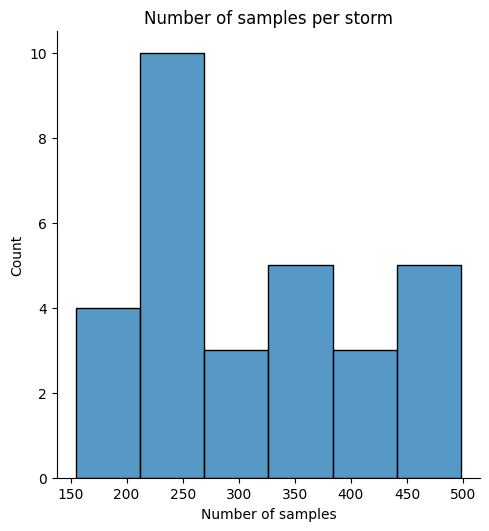

In [18]:
sns.displot(df.groupby('storm_id').size().sort_values(ascending=False))
plt.xlabel('Number of samples')
plt.title('Number of samples per storm');

Next, we were interested to see the number of samples per storm in our training data. We see that we have a range of sample numbers per storm, ranging between around 150 and 500 across our data.

## Exploring `wind_speed`


In [20]:
# Exploring distribution of mean wind speeds across storms
df.groupby('storm_id')[['wind_speed']].mean().sort_values('wind_speed', ascending=False)

,wind_speed
storm_id,
psz,96.791557
pvj,83.142241
wsy,83.123690
kqu,76.879870
sxb,72.271605
hig,69.529240
dzw,68.681199
ipa,68.630290
eoi,68.325820


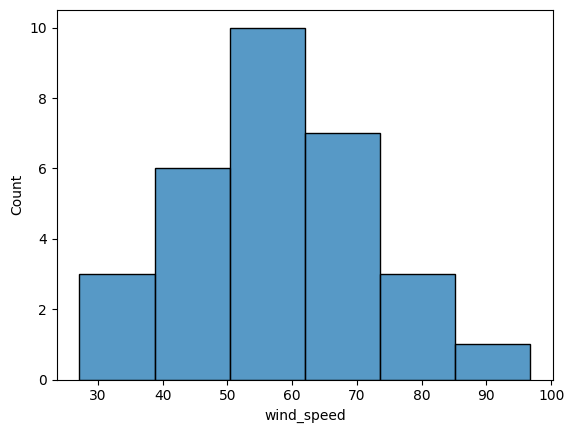

In [21]:
# Mean wind speed across storms
sns.histplot(df.groupby('storm_id')[['wind_speed']].mean().sort_values('wind_speed', ascending=False)['wind_speed']);

First, we were curious to see the distribution of mean wind speeds across storms in our data to see if our storms have similar wind speeds, on average. The histogram shows that we have a range of average wind speeds per storm, with average wind speed falling around 60 for most of our storms.

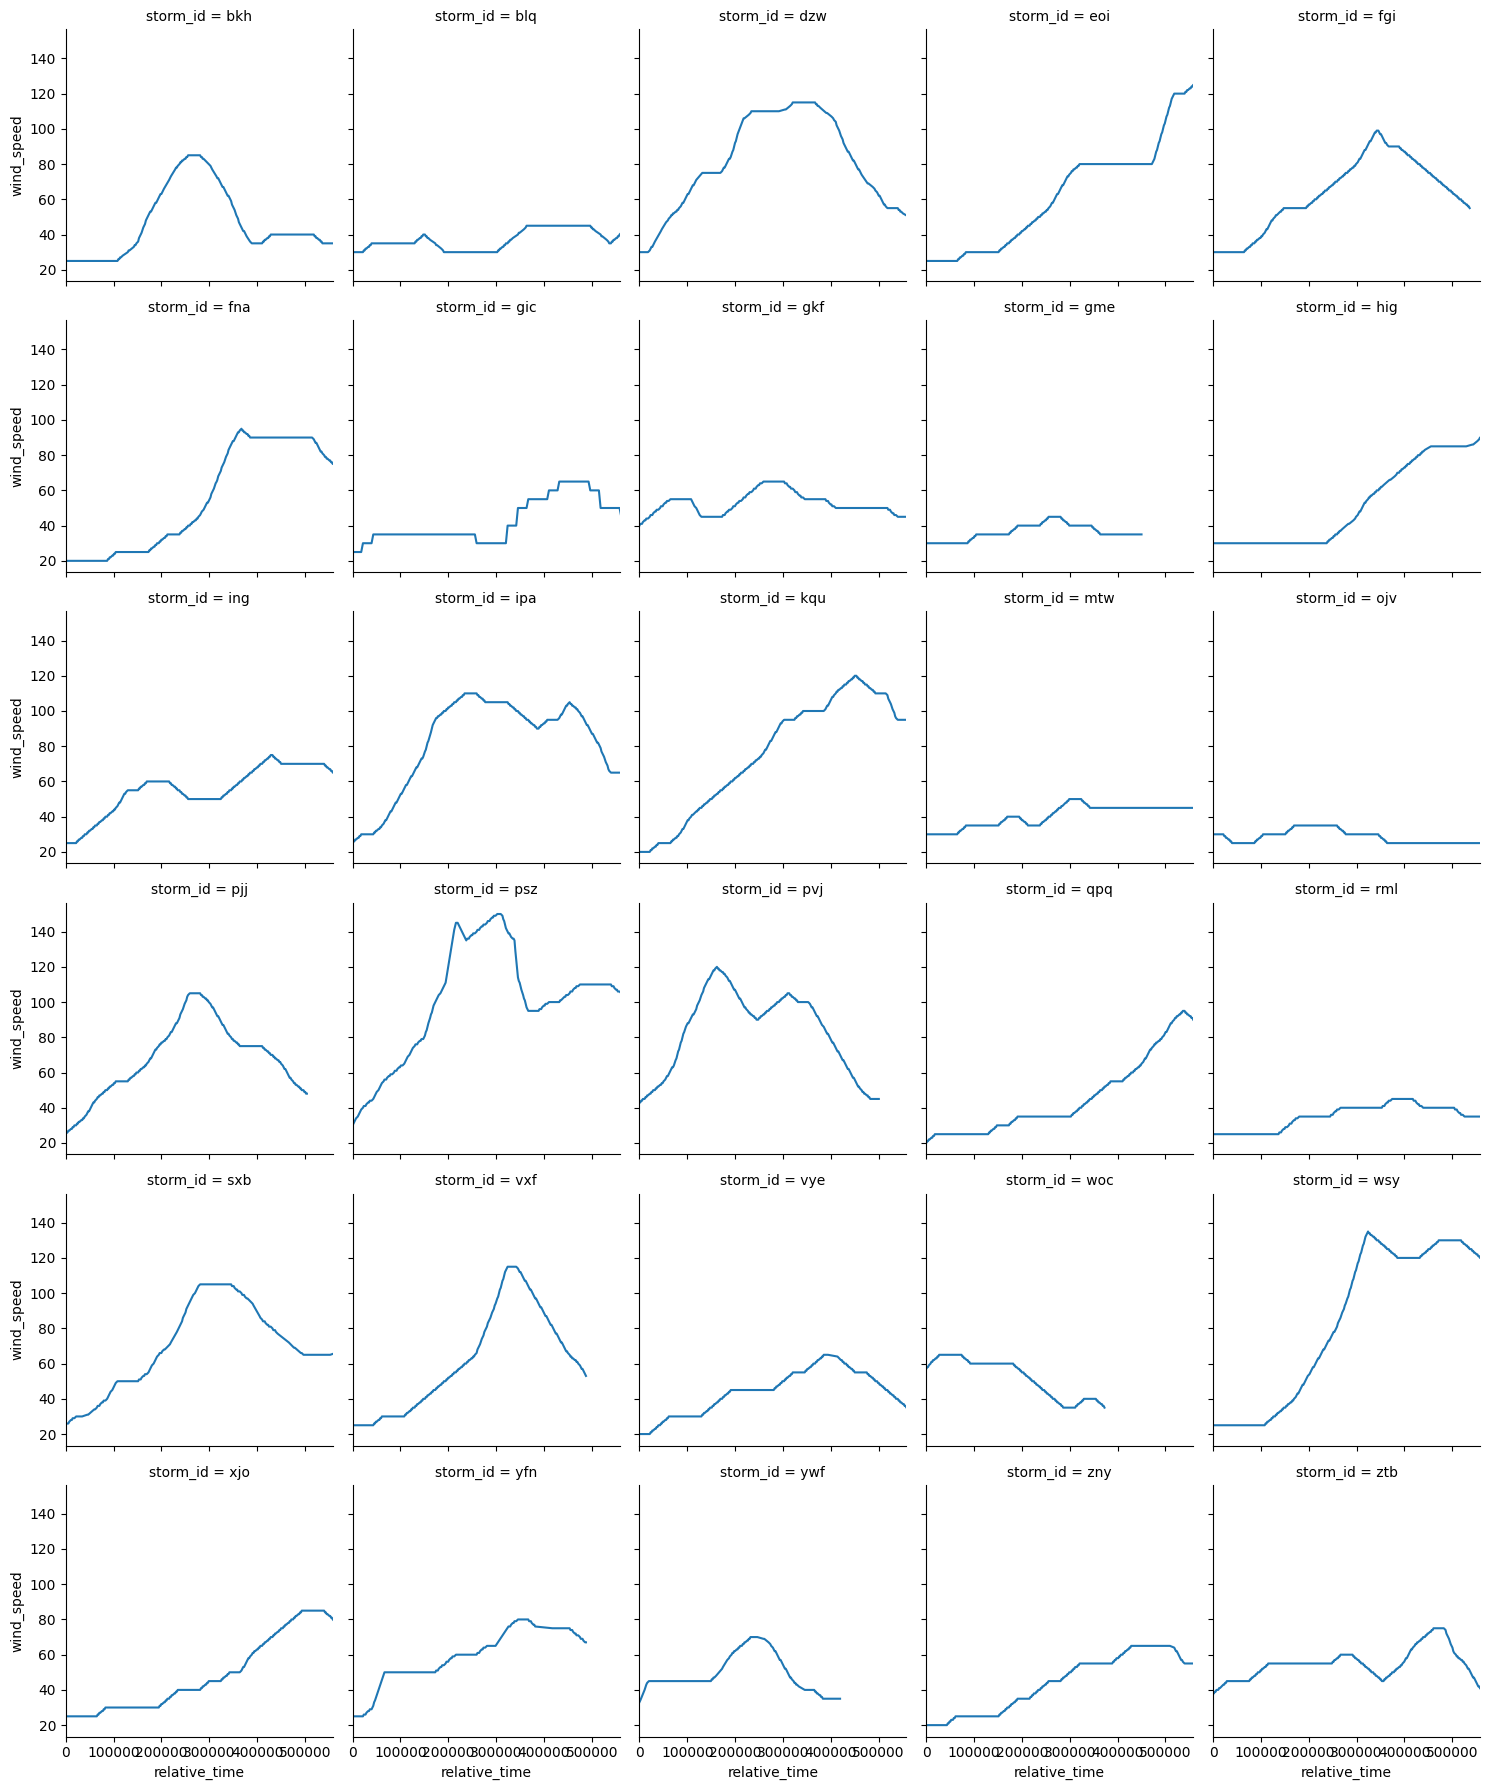

In [22]:
grid = sns.FacetGrid(df, col='storm_id', col_wrap=5, height=3)
grid.map(sns.lineplot, 'relative_time', 'wind_speed')
for storm_id, ax in grid.axes_dict.items():
    storm_data = df[df['storm_id'] == storm_id]
    x_min, x_max = storm_data['relative_time'].min(), storm_data['relative_time'].max()
    ax.set_xlim(x_min, x_max)
plt.tight_layout();

Next, we were curious to track the trajectories of wind speed across our storms as the storms progress. We see a range of trends between our storms, with some only increasing in wind speed, others increasing and then decreasing, while others yet sort of plateau or don't change much across time steps.

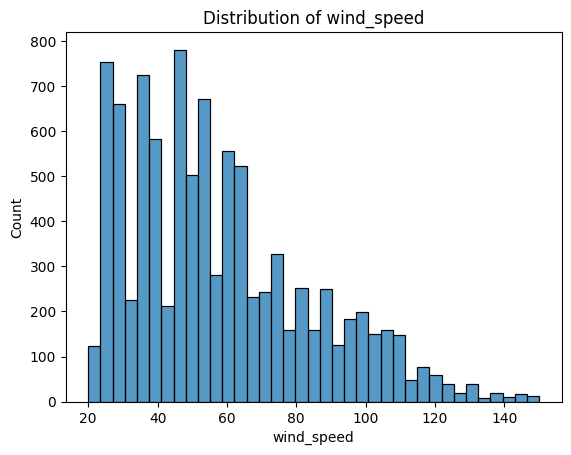

In [23]:
# Overall distribution of wind speeds across samples
sns.histplot(df['wind_speed'])
plt.title('Distribution of wind_speed');

Finally, we are visualizing the overall distribution of wind speeds across all samples. We see that we have obersvations of wind speeds up to around 140, while most observations have wind speeds falling in the range between 20 and 60.

## Exploring `ocean`

In [24]:
# Checking for balance of ocean 1 vs ocean 2
df['ocean'].value_counts()

1    7652
2    1875
Name: ocean, dtype: int64

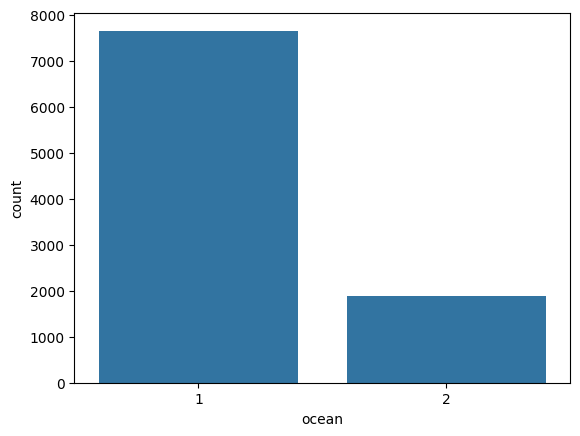

In [25]:
# Plotting distribution of ocean 1 vs ocean 2
sns.countplot(x='ocean', data=df);

Here, we are investigating the distribution of our `ocean` variable. We find that our data is quite unevenly distributed, with about 20% of samples taken from ocean 2, and the other 80% arising from ocean 1. This raises questions around rebalancing our data. Therefore, we want to see if we find any difference in the wind speeds across both oceans.

## Exploring `wind_speed` across `ocean`

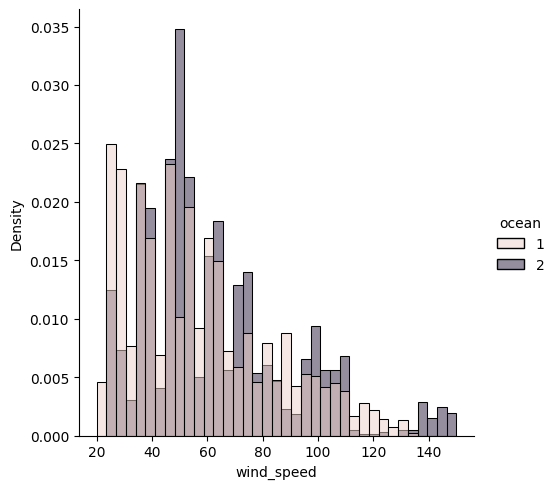

In [26]:
# Exploring distribution of wind_speed across samples in ocean 1 vs ocean 2
sns.displot(df, x='wind_speed', hue='ocean', stat='density', common_norm=False);

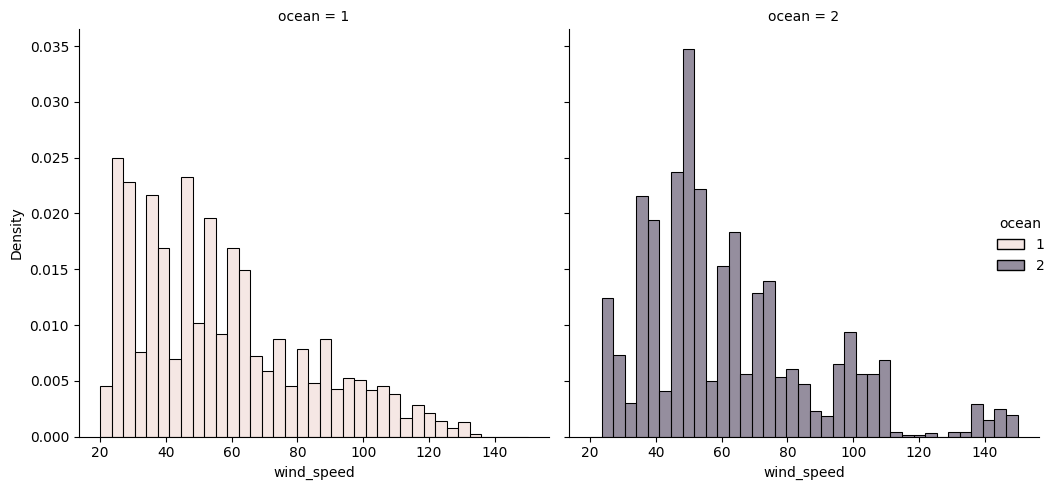

In [27]:
# Side-by-side view of wind_speed distributions
sns.displot(df, x='wind_speed', hue='ocean', stat='density', common_norm=False, col='ocean', col_wrap=2)
plt.tight_layout();

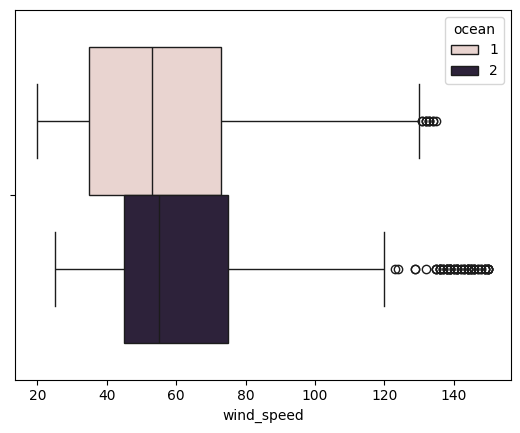

In [28]:
# Boxplot view of wind_speed distributions
sns.boxplot(df, x='wind_speed', hue='ocean');

Looking at the distribution of `wind_speed` across both oceans shows that the distribution for ocean 2 is skewed further towards high wind speeds. The overall shapes of the distributions is quite similar, and it is somewhat ambiguous whethere there is a distinct difference in distributions, or if the observed difference is the result of the relative sample sizes (ocean 2 has much smaller sample size).

## Exploring `relative_time`

Next, we are very intersted to see the distribution of `relative time`, and investigating whether our samples were collected at similar time intervals across storms.

In [29]:
# Adding time_step variable, with time steps calculated per storm
df['time_step'] = df.groupby('storm_id')[['relative_time']].diff()['relative_time']

In [30]:
df.head()

,storm_id,sample_number,relative_time,ocean,wind_speed,time_step
0,bkh,0,0,1,25.0,NaN
1,bkh,1,1801,1,25.0,1801.0
2,bkh,2,3600,1,25.0,1799.0
3,bkh,3,5400,1,25.0,1800.0
4,bkh,4,7200,1,25.0,1800.0


In [31]:
# time_step statistics
df['time_step'].describe()

count     9497.000000
mean      2368.601558
std       1548.305885
min       1395.000000
25%       1800.000000
50%       1800.000000
75%       3598.000000
max      61500.000000
Name: time_step, dtype: float64

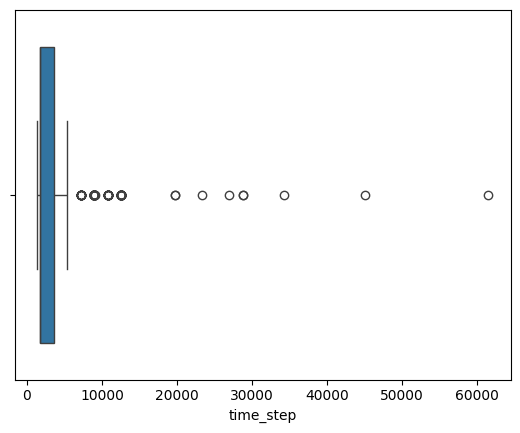

In [32]:
# Distribution of time_step across entire dataset
sns.boxplot(df, x='time_step');

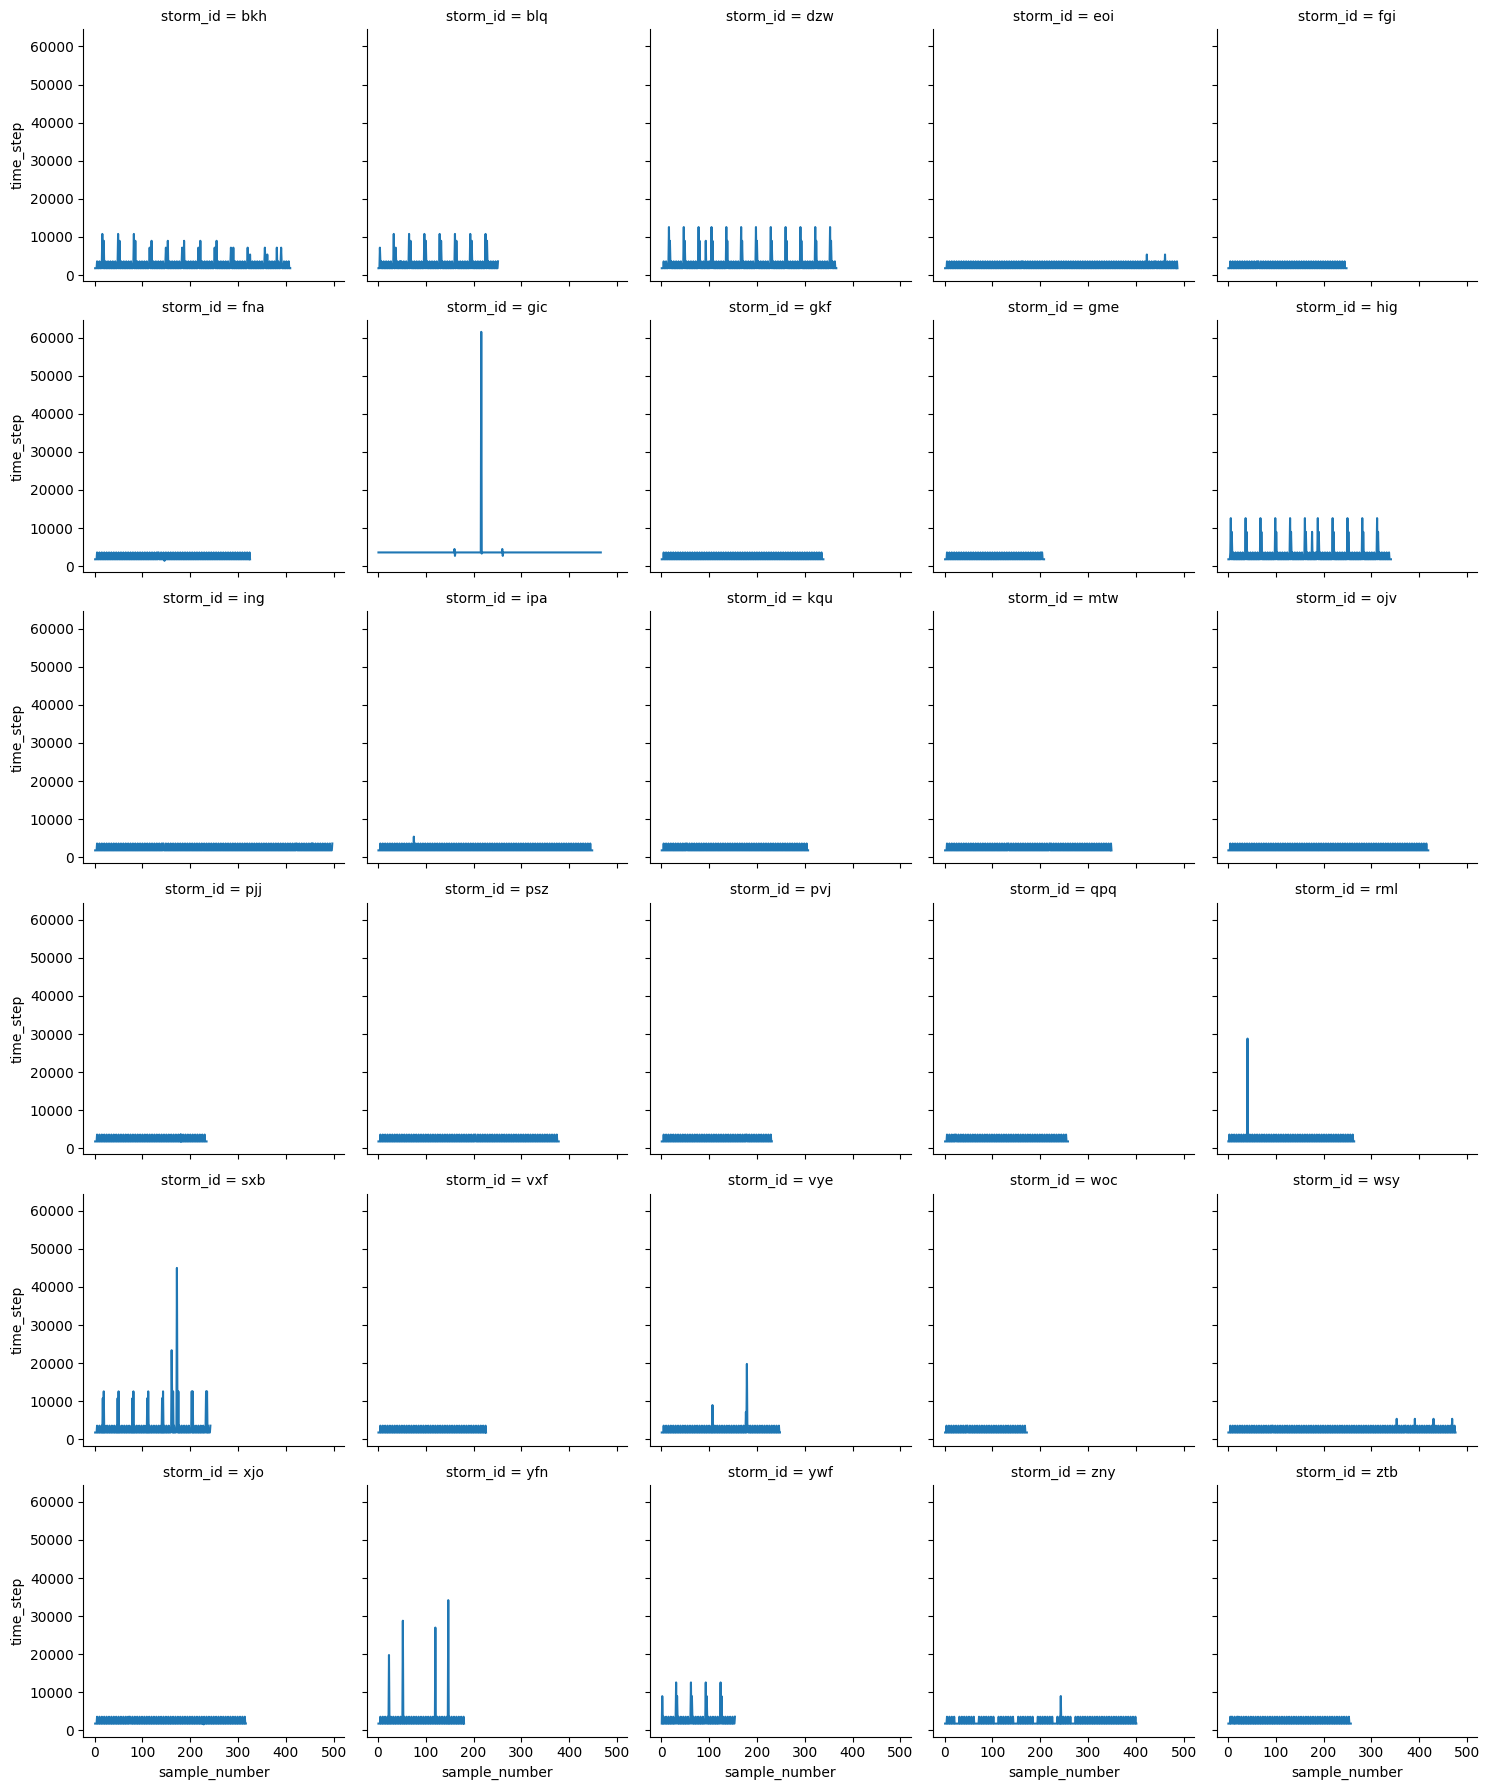

In [33]:
# sample_number vs time_step per storm
grid = sns.FacetGrid(df, col='storm_id', col_wrap=5, height=3)
grid.map(sns.lineplot, 'sample_number', 'time_step')
plt.tight_layout()

<Axes: xlabel='sample_number', ylabel='time_step'>

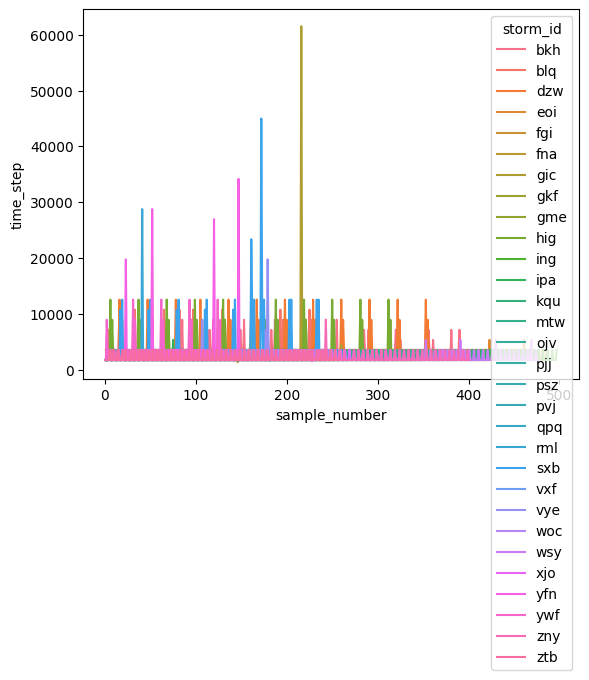

In [34]:
# time steps across storms, overlaid
sns.lineplot(df, x='sample_number', y='time_step', hue='storm_id')

These plots help show that the time steps between samples is not consistent across and within storms. Our 25th and 75th percentiles of `time_step` fall between 1500 and 3600; however, we have a few significant outliers, where data was collected with a large time interval (up to 60,000) between samples.


The `gic` storm saw the greatest outlier in `time_step` at 61,500. The storms `rml`, `sxb` and `yfn` also had instances of unsually large time intervals between samples.


This raises the idea of potentially interpolating between between large time samples in case consistent time steps is crucial for our networks. This could potentially be addressed by a generative model that can generate storm images for intermediate time steps. Our implementation of this idea with depend on time and resources.

# Exploring Images

We wanted to unserstand the image files included in our training data. We will be exploring the dimensions of the image tensors, and seeing what our images look like.

In [37]:
# Loading all training images -- takes long time to load, can't include in final analysis
#images = []
#for i in range(len(dataset)):
#    if i % 100 == 0:
#      print(i)
#      images.append(dataset[i]['image'])

In [38]:
# Picking an image sample
first_sample = dataset[0]
print(first_sample)

{'storm_id': 'bkh', 'sample_number': '000', 'relative_time': 0, 'ocean': 1, 'wind_speed': 25.0, 'image': tensor([[[0.2471, 0.3373, 0.4314,  ..., 0.0431, 0.0431, 0.0392],
         [0.2431, 0.3255, 0.4118,  ..., 0.0431, 0.0431, 0.0392],
         [0.2863, 0.3569, 0.4235,  ..., 0.0431, 0.0431, 0.0392],
         ...,
         [0.0588, 0.0627, 0.0667,  ..., 0.1647, 0.1843, 0.2039],
         [0.0627, 0.0667, 0.0706,  ..., 0.1725, 0.1882, 0.2039],
         [0.0588, 0.0667, 0.0706,  ..., 0.1647, 0.1804, 0.1922]]])}


In [39]:
# Exploring tensor dimensions
first_sample['image'].shape

torch.Size([1, 366, 366])

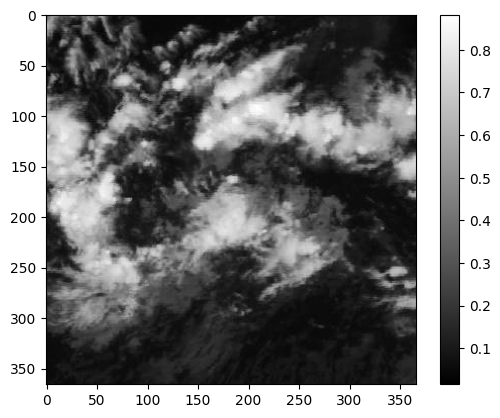

In [40]:
# Visualizing a sample image
plt.imshow(first_sample['image'].squeeze().numpy(), cmap='gray')
plt.colorbar();

In [41]:
# Investigating ranges of pixel values
min = first_sample['image'].min().item()
max = first_sample['image'].max().item()

print("Overall Min Value:", min)
print("Overall Max Value:", max)

Overall Min Value: 0.01568627543747425
Overall Max Value: 0.8823529481887817


Here, we looked at dimensions and pixel values across all images, and show the results for a single sample. When looking at all images, we identified that some images had dimensions (3, 1096, 1096), while most were (1, 366, 366). All images had pixel values between 0 and 1.

# Addressing missing pixels

We also noticed that some of our images had missing pixel values, which appear as white patches. Below is some experimentation to interpolate the missing pixel values.

In [42]:
# Loading images for storm with missing pixels (storm_id = 'ztb')
ztb_images = []
for i in df[df['storm_id']=='ztb'].index.to_list():
    ztb_images.append(dataset[i]['image'])

In [43]:
# Function to interpolate white space in image
# References: https://chat.openai.com/share/e2e94e48-0974-4bcb-a713-690f3bec8b15

def interpolate_image(image, missing_value=0.85, paint_radius=3):

    mask = (image >= missing_value).float()

    image_np = (image*255).squeeze().numpy().astype(np.uint8)
    mask_np = (mask*255).squeeze().numpy().astype(np.uint8)

    filled_image_np = cv2.inpaint(image_np, mask_np, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    filled_image_tensor = torch.from_numpy(filled_image_np) / 255.0

    return filled_image_tensor

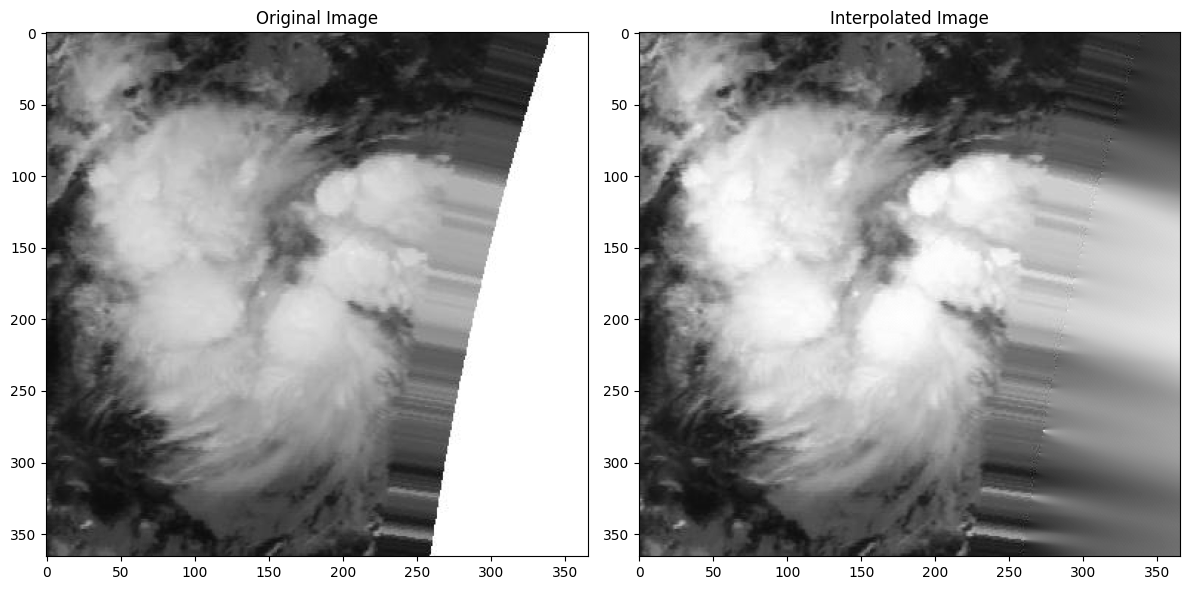

In [44]:
# Demonstrating interpolation for first ztb image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(ztb_images[0].squeeze().numpy(), cmap='gray', aspect='auto')
axes[0].set_title('Original Image')

axes[1].imshow(interpolate_image(ztb_images[0], missing_value=0.85, paint_radius=4), cmap='gray', aspect='auto')
axes[1].set_title('Interpolated Image')

plt.tight_layout();

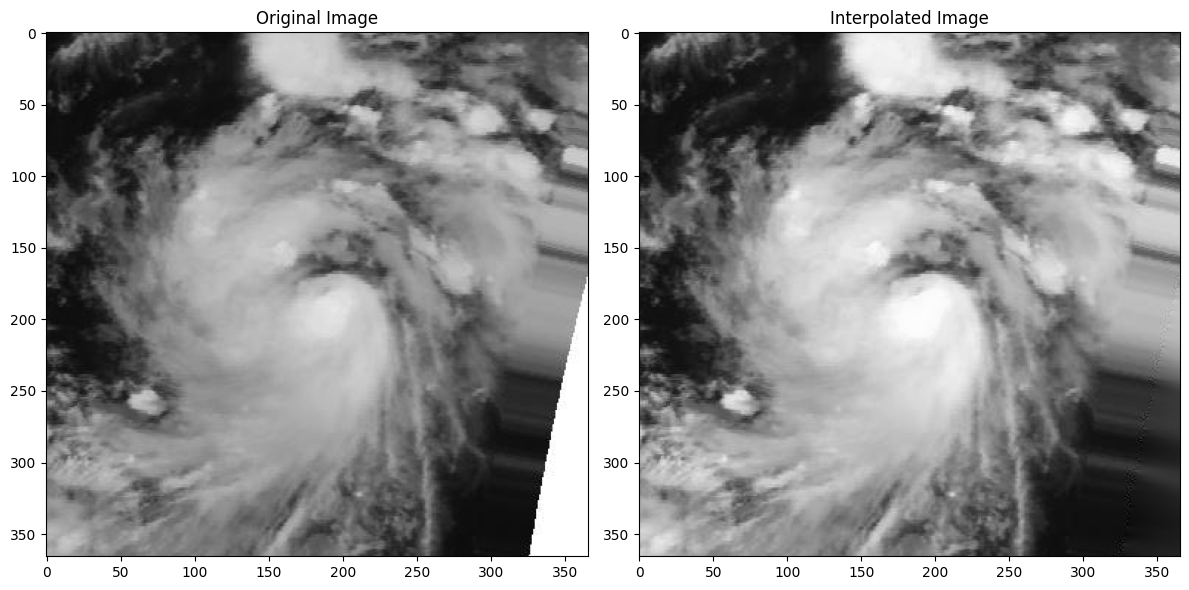

In [45]:
# Demonstrating interpolation for 15th ztb image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(ztb_images[14].squeeze().numpy(), cmap='gray', aspect='auto')
axes[0].set_title('Original Image')

axes[1].imshow(interpolate_image(ztb_images[14], missing_value=0.85, paint_radius=4), cmap='gray', aspect='auto')
axes[1].set_title('Interpolated Image')

plt.tight_layout();